# 基于AI的侧信道分析简介

这里我们使用ASCAD中的方法来描述一下基于AI的侧信道分析实验。总体的思路为：
1. 采集$N=N_1+N_2$条曲线，其中$N_1$条用于训练，$N_2$条用于攻击。
2. 选定一个AI模型对$N_1$条曲线进行学习，得到模型M.
3. 用模型M对$N_2$条攻击曲线进行分析

这里使用tensorflow 2来进行训练和预测等。

## 训练阶段

In [8]:
import os
import os.path
import sys
import h5py
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, AveragePooling1D, BatchNormalization, Activation, Add, add
from tensorflow.keras import backend as K
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
import zarr

In [ ]:
!pip install zarr

In [9]:

def check_file_exists(file_path):
	file_path = os.path.normpath(file_path)
	if os.path.exists(file_path) == False:
		print("Error: provided file path '%s' does not exist!" % file_path)
		sys.exit(-1)
	return

#### ASCAD中定义的MLP模型 (6 layers of 200 units)
def mlp_best(node=200,layer_nb=6,input_dim=1400):
	model = Sequential()
	model.add(Dense(node, input_dim=input_dim, activation='relu'))
	for i in range(layer_nb-2):
		model.add(Dense(node, activation='relu'))
	model.add(Dense(256, activation='softmax'))
	optimizer = RMSprop(learning_rate=0.00001)
	model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	return model

In [3]:
#### ASCAD helper to load profiling and attack data (traces and labels)
# Loads the profiling and attack datasets from the ASCAD
#  database
# def load_ascad(ascad_database_file, load_metadata=False):
# 	check_file_exists(ascad_database_file)
# 	# Open the ASCAD database HDF5 for reading
# 	try:
# 		in_file	 = h5py.File(ascad_database_file, "r")
# 	except:
# 		print("Error: can't open HDF5 file '%s' for reading (it might be malformed) ..." % ascad_database_file)
# 		sys.exit(-1)
# 	# Load profiling traces
# 	X_profiling = np.array(in_file['Profiling_traces/traces'], dtype=np.int8)
# 	# Load profiling labels
# 	Y_profiling = np.array(in_file['Profiling_traces/labels'])
# 	# Load attacking traces
# 	X_attack = np.array(in_file['Attack_traces/traces'], dtype=np.int8)
# 	# Load attacking labels
# 	Y_attack = np.array(in_file['Attack_traces/labels'])
# 	if load_metadata == False:
# 		return (X_profiling, Y_profiling), (X_attack, Y_attack)
# 	else:
# 		return (X_profiling, Y_profiling), (X_attack, Y_attack), (in_file['Profiling_traces/metadata'], in_file['Attack_traces/metadata'])

In [10]:
Sbox = [99, 124, 119, 123, 242, 107, 111, 197, 48, 1, 103, 43, 254, 215, 171, 118, 202, 130, 201, 125, 250, 89, 71,
        240, 173, 212, 162, 175, 156, 164, 114, 192, 183, 253, 147, 38, 54, 63, 247, 204, 52, 165, 229, 241, 113, 216,
        49, 21, 4, 199, 35, 195, 24, 150, 5, 154, 7, 18, 128, 226, 235, 39, 178, 117, 9, 131, 44, 26, 27, 110, 90, 160,
        82, 59, 214, 179, 41, 227, 47, 132, 83, 209, 0, 237, 32, 252, 177, 91, 106, 203, 190, 57, 74, 76, 88, 207, 208,
        239, 170, 251, 67, 77, 51, 133, 69, 249, 2, 127, 80, 60, 159, 168, 81, 163, 64, 143, 146, 157, 56, 245, 188,
        182, 218, 33, 16, 255, 243, 210, 205, 12, 19, 236, 95, 151, 68, 23, 196, 167, 126, 61, 100, 93, 25, 115, 96,
        129, 79, 220, 34, 42, 144, 136, 70, 238, 184, 20, 222, 94, 11, 219, 224, 50, 58, 10, 73, 6, 36, 92, 194, 211,
        172, 98, 145, 149, 228, 121, 231, 200, 55, 109, 141, 213, 78, 169, 108, 86, 244, 234, 101, 122, 174, 8, 186,
        120, 37, 46, 28, 166, 180, 198, 232, 221, 116, 31, 75, 189, 139, 138, 112, 62, 181, 102, 72, 3, 246, 14, 97,
        53, 87, 185, 134, 193, 29, 158, 225, 248, 152, 17, 105, 217, 142, 148, 155, 30, 135, 233, 206, 85, 40, 223, 140,
        161, 137, 13, 191, 230, 66, 104, 65, 153, 45, 15, 176, 84, 187, 22]

HW_byte = [0, 1, 1, 2, 1, 2, 2, 3, 1, 2, 2, 3, 2, 3, 3, 4, 1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 1, 2, 2,
            3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 1, 2, 2, 3, 2, 3,
            3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 2, 3, 3, 4, 3, 4, 4, 5, 3,
            4, 4, 5, 4, 5, 5, 6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4,
            3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5,
            6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 3, 4,
            4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 4, 5, 5, 6, 5,
            6, 6, 7, 5, 6, 6, 7, 6, 7, 7, 8]

In [11]:
#### Training high level function
def train_model(X_profiling, Y_profiling, model, save_file_name, epochs=150, batch_size=100, multilabel=0, validation_split=0, early_stopping=0):
	check_file_exists(os.path.dirname(save_file_name))
	# Save model calllback
	save_model = ModelCheckpoint(save_file_name)
	callbacks=[save_model]
	# Early stopping callback
	if (early_stopping != 0):
		if validation_split == 0:
			validation_split=0.1
		callbacks.append(EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True))
	# Get the input layer shape
	if isinstance(model.input_shape, list):
		input_layer_shape = model.input_shape[0]
	else:
		input_layer_shape = model.input_shape
	# Sanity check
	
	if input_layer_shape[1] != len(X_profiling[0]):
		print("Error: model input shape %d instead of %d is not expected ..." % (input_layer_shape[1], len(X_profiling[0])))
		sys.exit(-1)
	# Adapt the data shape according our model input
	if len(input_layer_shape) == 2:
		# This is a MLP
		Reshaped_X_profiling = X_profiling
	elif len(input_layer_shape) == 3:
		# This is a CNN: expand the dimensions
		Reshaped_X_profiling = X_profiling.reshape((X_profiling.shape[0], X_profiling.shape[1], 1))
	else:
		print("Error: model input shape length %d is not expected ..." % len(input_layer_shape))
		sys.exit(-1)
	
	y=to_categorical(Y_profiling, num_classes=256)
	history = model.fit(x=Reshaped_X_profiling, y=y, batch_size=batch_size, verbose = 1, validation_split=validation_split, epochs=epochs, callbacks=callbacks)
	return history

In [19]:
dataset_name = r'D:\project\tutorials\dataset\20241020094826.zarr'
traceset = zarr.open(dataset_name, mode='r')
traceset['0/0/traces'].shape

(10, 20480)

In [16]:
network_type = "mlp"
training_model = "models\\my_mlp_best.keras"
validation_split = 0
multilabel = 0
train_len = 0
epochs = 100
batch_size = 200
bugfix = 0
dataset_name = 'dataset\\20241121073628.zarr'
traceset = zarr.open(dataset_name, mode='r')
trace_length = 500
begin_index = 200
X_profiling = np.array(traceset['0/0/traces'][:45000,begin_index:(begin_index+trace_length)])
plaintexts_source = traceset['0/0/plaintext'][:45000,0]
Y_profiling = np.zeros(45000, dtype = np.uint8)
keyb = 0x11
labeling_method = 'identity' # labeling of trace
if labeling_method == 'identity':
    class_num = 256
    for i in range(45000):
        Y_profiling[i] = int(Sbox[plaintexts_source[i] ^ keyb])
elif labeling_method == 'hw':
    class_num = 9
    for i in range(45000):
        Y_profiling[i] = HW_byte[int(Sbox[plaintexts_source[i] ^ keyb])]


best_model = mlp_best(input_dim=len(X_profiling[0]))

#  print best_model.summary()

### training
if (train_len == 0):
    train_model(X_profiling, Y_profiling, best_model, training_model, epochs, batch_size, multilabel, validation_split)
else:
    train_model(X_profiling[:train_len], Y_profiling[:train_len], best_model, training_model, epochs, batch_size, multilabel, validation_split)


IndexError: index 10 is out of bounds for axis 0 with size 10

## 分析阶段

In [7]:
def load_sca_model(model_file):
	check_file_exists(model_file)
	try:
		model = load_model(model_file)
	except:
		print("Error: can't load Keras model file '%s'" % model_file)
		sys.exit(-1)
	return model

# Compute the rank of the real key for a give set of predictions
def rank(predictions, metadata, real_key, min_trace_idx, max_trace_idx, last_key_bytes_proba, target_byte, simulated_key):
	# Compute the rank
	if len(last_key_bytes_proba) == 0:
		# If this is the first rank we compute, initialize all the estimates to zero
		key_bytes_proba = np.zeros(256)
	else:
		# This is not the first rank we compute: we optimize things by using the
		# previous computations to save time!
		key_bytes_proba = last_key_bytes_proba

	for p in range(0, max_trace_idx-min_trace_idx):
		# Go back from the class to the key byte. '2' is the index of the byte (third byte) of interest.
		plaintext = metadata[min_trace_idx + p][target_byte]
		# key = metadata[min_trace_idx + p]['key'][target_byte]
		for i in range(0, 256):
			# Our candidate key byte probability is the sum of the predictions logs
			if (simulated_key!=1):
				proba = predictions[p][Sbox[plaintext ^ i]]
			else:
				proba = predictions[p][Sbox[plaintext ^ key ^ i]]
			if proba != 0:
				key_bytes_proba[i] += np.log(proba)
			else:
				# We do not want an -inf here, put a very small epsilon
				# that correspondis to a power of our min non zero proba
				min_proba_predictions = predictions[p][np.array(predictions[p]) != 0]
				if len(min_proba_predictions) == 0:
					print("Error: got a prediction with only zeroes ... this should not happen!")
					sys.exit(-1)
				min_proba = min(min_proba_predictions)
				key_bytes_proba[i] += np.log(min_proba**2)
	# Now we find where our real key candidate lies in the estimation.
	# We do this by sorting our estimates and find the rank in the sorted array.
	sorted_proba = np.array(list(map(lambda a : key_bytes_proba[a], key_bytes_proba.argsort()[::-1])))
	real_key_rank = np.where(sorted_proba == key_bytes_proba[real_key])[0][0]
	return (real_key_rank, key_bytes_proba)

def full_ranks(predictions, dataset, metadata, min_trace_idx, max_trace_idx, rank_step, target_byte, simulated_key):
	print("Computing rank for targeted byte {}".format(target_byte))
	# Real key byte value that we will use. '2' is the index of the byte (third byte) of interest.
	
	real_key = 0x11
	# Check for overflow
	if max_trace_idx > dataset.shape[0]:
		print("Error: asked trace index %d overflows the total traces number %d" % (max_trace_idx, dataset.shape[0]))
		sys.exit(-1)
	index = np.arange(min_trace_idx+rank_step, max_trace_idx, rank_step)
	f_ranks = np.zeros((len(index), 2), dtype=np.uint32)
	key_bytes_proba = []
	for t, i in zip(index, range(0, len(index))):
		real_key_rank, key_bytes_proba = rank(predictions[t-rank_step:t], metadata, real_key, t-rank_step, t, key_bytes_proba, target_byte, simulated_key)
		f_ranks[i] = [t - min_trace_idx, real_key_rank]
	return f_ranks

def proba_dissect_beta(proba_sboxmuladd, proba_beta):
	proba = np.zeros(proba_sboxmuladd.shape)
	for j in range(proba_beta.shape[1]):
		proba_sboxdeadd = proba_sboxmuladd[:, [(beta^j) for beta in range(256)]]
		proba[:,j] = np.sum(proba_sboxdeadd*proba_beta, axis=1)
	return proba

# Compute Pr(Sbox(p^k)|t)
def proba_dissect_alpha(proba_sboxmul, proba_alpha):
	proba = np.zeros(proba_sboxmul.shape)
	for j in range(proba_alpha.shape[1]):
		proba_sboxdemul = proba_sboxmul[:, [multGF256(alpha,j) for alpha in range(256)]]
		proba[:,j] = np.sum(proba_sboxdemul*proba_alpha, axis=1)
	return proba

# Compute Pr(Sbox(p[permind]^k[permind])|t)
def proba_dissect_permind(proba_x, proba_permind, j):
	proba = np.zeros((proba_x.shape[0], proba_x.shape[2]))
	for s in range(proba_x.shape[2]):
		proba_1 = proba_x[:,:,s]
		proba_2 = proba_permind[:,:,j]
		proba[:,s] = np.sum(proba_1*proba_2, axis=1)
	return proba

In [10]:
import matplotlib.pyplot as plt
# Check a saved model against one of the ASCAD databases Attack traces
def check_model(model_file, ascad_database, num_traces=2000, target_byte=0, multilabel=0, simulated_key=0, save_file=""):
	check_file_exists(model_file)
	# check_file_exists(ascad_database)
	# Load profiling and attack data and metadata from the ASCAD database
	# (X_profiling, Y_profiling), (X_attack, Y_attack), (Metadata_profiling, Metadata_attack) = load_ascad(ascad_database, load_metadata=True)
	dataset_name = 'dataset\\20241121073628.zarr'
	traceset = zarr.open(dataset_name, mode='r')
	trace_length = 500
	begin_index = 200
	X_attack = np.array(traceset['0/0/traces'][45000:,begin_index:(begin_index+trace_length)])
	Metadata_attack = traceset['0/0/plaintext'][45000:]
	# Y_profiling = np.zeros(5000, dtype = np.uint8)
	# keyb = 0x11
	# labeling_method = 'identity' # labeling of trace
	# if labeling_method == 'identity':
	# 	class_num = 256
	# 	for i in range(5000):
	# 		Y_profiling[i] = int(AES_Sbox[plaintexts_source[i] ^ keyb])
	# elif labeling_method == 'hw':
	# 	class_num = 9
	# 	for i in range(5000):
	# 		Y_profiling[i] = HW_byte[int(AES_Sbox[plaintexts_source[i] ^ keyb])]
	# Load model
	model = load_sca_model(model_file)
	# Get the input layer shape
	if isinstance(model.input_shape, list):
		input_layer_shape = model.input_shape[0]
	else:
		input_layer_shape = model.input_shape
	# Sanity check
	if input_layer_shape[1] != len(X_attack[0, :]):
		print("Error: model input shape %d instead of %d is not expected ..." % (input_layer_shape[1], len(X_attack[0, :])))
		sys.exit(-1)
	# Adapt the data shape according our model input
	if len(input_layer_shape) == 2:
		# This is a MLP
		input_data = X_attack[:num_traces, :]
	elif len(input_layer_shape) == 3:
		# This is a CNN: reshape the data
		input_data = X_attack[:num_traces, :]
		input_data = input_data.reshape((input_data.shape[0], input_data.shape[1], 1))
	else:
		print("Error: model input shape length %d is not expected ..." % len(input_layer_shape))
		sys.exit(-1)
	# Predict our probabilities
	predictions = model.predict(input_data)
	
	predictions_sbox_i = predictions
	# We test the rank over traces of the Attack dataset, with a step of 10 traces
	ranks = full_ranks(predictions_sbox_i, X_attack, Metadata_attack, 0, num_traces, 10, target_byte, simulated_key)
	# We plot the results
	x = [ranks[i][0] for i in range(0, ranks.shape[0])]
	y = [ranks[i][1] for i in range(0, ranks.shape[0])]
	plt.title('Performance of '+model_file+' against '+ascad_database)
	plt.xlabel('number of traces')
	plt.ylabel('rank')
	plt.grid(True)
	plt.plot(x, y)
	plt.show()
	# if (save_file != ""):
	# 	plt.savefig(save_file)
	# else:
	# 	plt.show(block=False)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Computing rank for targeted byte 0


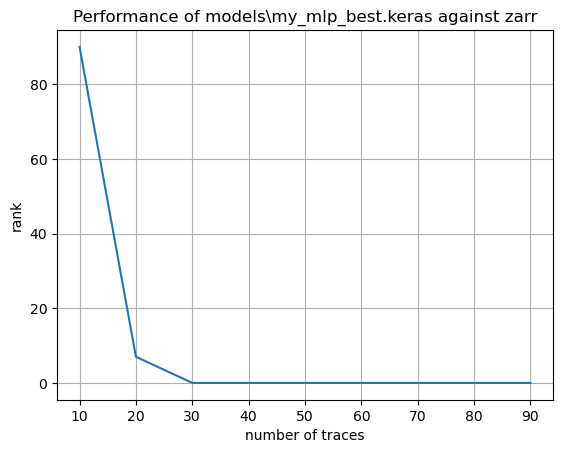

In [11]:
model_file="models\\my_mlp_best.keras"
ascad_database=traces_file="zarr"
num_traces=100
target_byte=0
multilabel=0
simulated_key=0
check_model(model_file, ascad_database, num_traces, target_byte, multilabel, simulated_key, "")